In [27]:
# --- Imports ---
import os
import glob
import nilearn 
import numpy as np 
import pandas as pd
import nibabel as nib

from numpy import savetxt
import matplotlib.pyplot as plt
from nilearn import plotting, image, datasets
from nilearn.plotting import plot_design_matrix
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix


# --- Init variables ---
init_folder='/home/traaffneu/margal/awake_code/awake/scripts/'
analysis_folder='/project/4180000.36/AwakeRodent/scratch/first_level/'

metadata_path = '/home/traaffneu/margal/awake_code/awake/scripts/tables/Awake_metadata.tsv'
df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

#### DEFINE VARIABLES

In [ ]:
# -- Chose the database to preproces -- 
rodent_specie = 'Mice'
#rodent_specie = 'Rats'

In [43]:
# --- Data path ---
template_rat_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
template_mouse_path = '/groupshare/traaffneu/preclinimg/templates/DSURQE/DSURQE_100micron_average.nii.gz'


# --- Output path ---
output_dir = '/project/4180000.36/AwakeRodent/scratch/second_level/'
subdirectories = ['Mice', 'Rats']

base_dir = os.path.join(output_dir, 'Mice') if rodent_specie == 'Mice' else os.path.join(output_dir, 'Rats')
if not os.path.exists(base_dir):os.makedirs(base_dir)

image_dir = os.path.join(base_dir, 'image/')
beta_dir = os.path.join(base_dir, 'beta_estimates/')
z_score_dir = os.path.join(base_dir, 'z_score/')
p_value_dir = os.path.join(base_dir, 'p_value/')

for subdir in subdirectories:
    sub_dir = os.path.join(output_dir, subdir)
    sub_dir_structure = ['image', 'beta_estimates', 'z_score', 'p_value']
    
    for sub_subdir in sub_dir_structure:
        dir_path = os.path.join(sub_dir, sub_subdir)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

#### SECOND LEVEL ANALYSIS

ID dataset: 01001
Scans included: 4


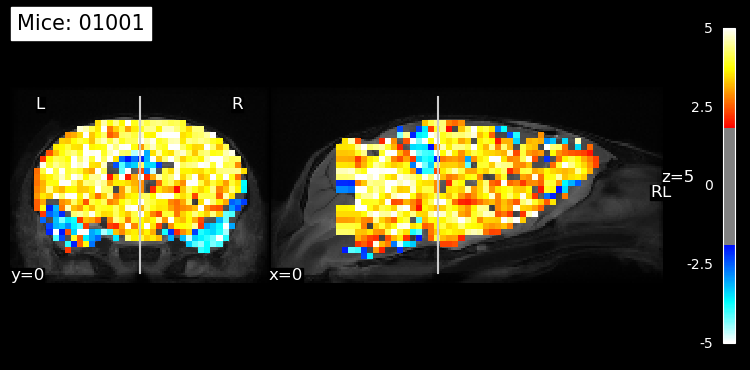

In [49]:
for index in range(1, 2):
    
    # --- Load data ---
    ID = "0"+str(1000+index)
    print("ID dataset:", ID)
 
    if rodent_specie == 'Mice':
        template = template_mouse_path
        dataset = glob.glob(analysis_folder+f"Mice/sub-{ID}??_*")        
    elif rodent_specie == 'Rats':
        template = template_rat_path
        dataset = glob.glob(analysis_folder+f"Rats/sub-{ID}??_*")
    else:
        print('No file to be saved. Check that hrf_function is well defined.')
    
    n_subject = len(dataset)                                                           
    print("Scans included:", n_subject)
    second_level_input = dataset

    # --- Design matrix and second-level model ---
    design_matrix = pd.DataFrame([1] * len(second_level_input), 
                                columns=["intercept"])
 
    second_level_model = SecondLevelModel(smoothing_fwhm=0.1,
                                          minimize_memory=False)        #if want to get residuals?

    second_level_model = second_level_model.fit(second_level_input,
                                                design_matrix=design_matrix)


    # --- Estimate the contrast --- 
    second_stat_map = second_level_model.compute_contrast(second_level_contrast='intercept', output_type='all') 

    p_val = 0.05
    plot_stat = plotting.plot_stat_map(second_stat_map['z_score'],
                                        bg_img = template,
                                        threshold = 1.9,              
                                        cut_coords= (0 ,0, 5.5),        
                                        display_mode='ortho',
                                        draw_cross=True,
                                        colorbar=True,
                                        vmax = 5, 
                                        title=f"{rodent_specie}: {ID}")

    # --- Save outputs ---  
    plt.savefig(image_dir+'stat_map_dataset-{}_z_score.png'.format(ID)) 
    nib.save(second_stat_map['z_score'], z_score_dir+'z_score_dataset-{}.nii.gz'.format(ID))          
    nib.save(second_stat_map['effect_size'], beta_dir+'beta_dataset-{}.nii.gz'.format(ID))            
    nib.save(second_stat_map['p_value'], p_value_dir+'p_value_dataset-{}.nii.gz'.format(ID))   

    
        